BRAIN TUMOR MRI IMAGE CLASSIFICATION

IMPORT THE IMAGE FILE SAVED IN LOCAL DEVICE

In [1]:
## Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import os

CHECKING THE NUMBER OF IMAGES PER CLASS IN TRAIN, VALIDATION AND TEST

In [ ]:
import os

data_dir = r"/Users/srividyarajagopalan/Desktop/My Files/Data Science/DS_Projects/Brain_Tumor_Image_Class/Tumor" # Path to the dataset
for split in ["train", "valid", "test"]:
    path = os.path.join(data_dir, split)
    print(f"\n{split.upper()} set:")
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            print(f" - {cls}: {len(os.listdir(cls_path))} images")


TRAIN set:
 - pituitary: 438 images
 - no_tumor: 335 images
 - glioma: 564 images
 - meningioma: 358 images

VALID set:
 - pituitary: 118 images
 - no_tumor: 99 images
 - glioma: 161 images
 - meningioma: 124 images

TEST set:
 - pituitary: 54 images
 - no_tumor: 49 images
 - glioma: 80 images
 - meningioma: 63 images


DATA PROCESSING AND AUGMENTATION

In [4]:
## Data pre-processing and loading
## Device configuration

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

data = r"/Users/srividyarajagopalan/Desktop/My Files/Data Science/DS_Projects/Brain_Tumor_Image_Class/Tumor"
train_dir = os.path.join(data, 'train')
test_dir = os.path.join(data, 'test')
valid_dir = os.path.join(data, 'valid')


## Hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.0001

## Load Image dataset
batch_size=32
train_transform = transforms.Compose(
    [transforms.Resize((224,224)),
     ##augmentation can be added here like RandomHorizontalFlip, RandomRotation etc 
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])

val_test_transform = transforms.Compose(
    [transforms.Resize((224,224)), 
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])

train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
valid_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform=val_test_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=val_test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Classes:", train_dataset.classes)
print("Train images:", len(train_dataset))
print("Valid images:", len(valid_dataset))
print("Test images:", len(test_dataset))

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Train images: 1695
Valid images: 502
Test images: 246


BUILD A CUSTOM CNN ARCHITECTURE

In [13]:
## Custom CNN Architecture
class ConvNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.batchnorm1(self.conv1(x))))  # -> [B, 32, H/2, W/2]
        x = self.pool(F.relu(self.batchnorm2(self.conv2(x))))  # -> [B, 64, H/4, W/4]
        x = self.pool(F.relu(self.batchnorm3(self.conv3(x))))  # -> [B, 128, H/8, W/8]

        x = x.view(-1, 128 * 28 * 28)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Train the model    
customcnn_model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(customcnn_model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = customcnn_model(images)
        loss = criterion(outputs, labels)

        #backward and optimize
        loss.backward()
        optimizer.step()
        
        print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')


## Testing the model
customcnn_model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = customcnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Epoch[1/5], Step [1/53, Loss: 1.4797]
Epoch[1/5], Step [2/53, Loss: 2.5051]
Epoch[1/5], Step [3/53, Loss: 5.3843]
Epoch[1/5], Step [4/53, Loss: 3.2761]
Epoch[1/5], Step [5/53, Loss: 4.5211]
Epoch[1/5], Step [6/53, Loss: 2.4355]
Epoch[1/5], Step [7/53, Loss: 2.4870]
Epoch[1/5], Step [8/53, Loss: 1.9705]
Epoch[1/5], Step [9/53, Loss: 3.6088]
Epoch[1/5], Step [10/53, Loss: 2.6217]
Epoch[1/5], Step [11/53, Loss: 2.6957]
Epoch[1/5], Step [12/53, Loss: 2.1622]
Epoch[1/5], Step [13/53, Loss: 1.2087]
Epoch[1/5], Step [14/53, Loss: 0.9234]
Epoch[1/5], Step [15/53, Loss: 1.4426]
Epoch[1/5], Step [16/53, Loss: 1.9468]
Epoch[1/5], Step [17/53, Loss: 1.8951]
Epoch[1/5], Step [18/53, Loss: 2.1054]
Epoch[1/5], Step [19/53, Loss: 1.5693]
Epoch[1/5], Step [20/53, Loss: 1.1714]
Epoch[1/5], Step [21/53, Loss: 0.4680]
Epoch[1/5], Step [22/53, Loss: 0.8925]
Epoch[1/5], Step [23/53, Loss: 1.6782]
Epoch[1/5], Step [24/53, Loss: 1.6721]
Epoch[1/5], Step [25/53, Loss: 1.3691]
Epoch[1/5], Step [26/53, Loss: 1.1

BEST ACCURACY - CUSTOMCNN - MODEL SAVED

TRANSFER LEARNING USING PRE-TRAINED MODELS

a. ResNet50

In [6]:
## Check for classes in Train dataset
train_dataset.classes

['glioma', 'meningioma', 'no_tumor', 'pituitary']

In [7]:
## ResNet50 model for BRAIN TUMOR dataset
## Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.0001

num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')


## Load the pretrained ResNet50 model
resnet50_model = torchvision.models.resnet50(pretrained=True)

## Freeze all the layers
for param in resnet50_model.parameters():
  param.requires_grad = False

in_features = resnet50_model.fc.in_features

## Modify the final layer to match the number of classes in Brain Tumor dataset
resnet50_model.fc = nn.Linear(in_features, num_classes)
model2 = resnet50_model.to(device)
## Test the pretrained ResNet50 model
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate, weight_decay=1e-6)
## Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model2(images)
        loss = criterion(outputs, labels)
        #backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')

## Testing the ResNet50 model
model2.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Number of classes: 4


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch[1/5], Step [1/53, Loss: 1.3488]
Epoch[1/5], Step [2/53, Loss: 1.4135]
Epoch[1/5], Step [3/53, Loss: 1.5274]
Epoch[1/5], Step [4/53, Loss: 1.5129]
Epoch[1/5], Step [5/53, Loss: 1.4641]
Epoch[1/5], Step [6/53, Loss: 1.3555]
Epoch[1/5], Step [7/53, Loss: 1.3253]
Epoch[1/5], Step [8/53, Loss: 1.3208]
Epoch[1/5], Step [9/53, Loss: 1.3253]
Epoch[1/5], Step [10/53, Loss: 1.3863]
Epoch[1/5], Step [11/53, Loss: 1.4967]
Epoch[1/5], Step [12/53, Loss: 1.3457]
Epoch[1/5], Step [13/53, Loss: 1.3786]
Epoch[1/5], Step [14/53, Loss: 1.4511]
Epoch[1/5], Step [15/53, Loss: 1.2964]
Epoch[1/5], Step [16/53, Loss: 1.2671]
Epoch[1/5], Step [17/53, Loss: 1.3865]
Epoch[1/5], Step [18/53, Loss: 1.3219]
Epoch[1/5], Step [19/53, Loss: 1.3830]
Epoch[1/5], Step [20/53, Loss: 1.3140]
Epoch[1/5], Step [21/53, Loss: 1.3451]
Epoch[1/5], Step [22/53, Loss: 1.2927]
Epoch[1/5], Step [23/53, Loss: 1.1515]
Epoch[1/5], Step [24/53, Loss: 1.2853]
Epoch[1/5], Step [25/53, Loss: 1.2815]
Epoch[1/5], Step [26/53, Loss: 1.2

b. MobileNet

In [8]:
## MobileNet model for BRAIN TUMOR dataset
## Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.0001

num_classes = len(train_dataset.classes)
print(f'Number of classes: {num_classes}')

## Load the pretrained MobileNet model
mobilenetv2_model = torchvision.models.mobilenet_v2(pretrained=True)

## Freeze all the layers
for param in mobilenetv2_model.parameters():
  param.requires_grad = False

in_features = mobilenetv2_model.classifier[1].in_features

## Modify the final layer to match the number of classes in Brain Tumor dataset
mobilenetv2_model.classifier[1] = nn.Linear(in_features, num_classes)
model3 = mobilenetv2_model.to(device)

## Test the pretrained MobileNet model
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate, weight_decay=1e-6)

## Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model3(images)
        loss = criterion(outputs, labels)
        #backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')

## Testing the MobileNet model
model3.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Number of classes: 4


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch[1/5], Step [1/53, Loss: 1.4370]
Epoch[1/5], Step [2/53, Loss: 1.3574]
Epoch[1/5], Step [3/53, Loss: 1.4768]
Epoch[1/5], Step [4/53, Loss: 1.3649]
Epoch[1/5], Step [5/53, Loss: 1.3492]
Epoch[1/5], Step [6/53, Loss: 1.4321]
Epoch[1/5], Step [7/53, Loss: 1.4060]
Epoch[1/5], Step [8/53, Loss: 1.3042]
Epoch[1/5], Step [9/53, Loss: 1.3730]
Epoch[1/5], Step [10/53, Loss: 1.3824]
Epoch[1/5], Step [11/53, Loss: 1.3115]
Epoch[1/5], Step [12/53, Loss: 1.2921]
Epoch[1/5], Step [13/53, Loss: 1.3811]
Epoch[1/5], Step [14/53, Loss: 1.3488]
Epoch[1/5], Step [15/53, Loss: 1.3613]
Epoch[1/5], Step [16/53, Loss: 1.3753]
Epoch[1/5], Step [17/53, Loss: 1.2835]
Epoch[1/5], Step [18/53, Loss: 1.4210]
Epoch[1/5], Step [19/53, Loss: 1.3022]
Epoch[1/5], Step [20/53, Loss: 1.4087]
Epoch[1/5], Step [21/53, Loss: 1.2114]
Epoch[1/5], Step [22/53, Loss: 1.3125]
Epoch[1/5], Step [23/53, Loss: 1.3097]
Epoch[1/5], Step [24/53, Loss: 1.2817]
Epoch[1/5], Step [25/53, Loss: 1.2811]
Epoch[1/5], Step [26/53, Loss: 1.2

c. InceptionV3

In [10]:
## InceptionV3 model for BRAIN TUMOR dataset
## Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.0001

## Load Image dataset

inceptionv3_train_transform = transforms.Compose(
    [transforms.Resize((299,299)),
     ##augmentation can be added here like RandomHorizontalFlip, RandomRotation etc 
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     transforms.CenterCrop(299),
     transforms.ToTensor(),
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])

inceptionv3_val_test_transform = transforms.Compose(
    [transforms.Resize((299,299)),
     transforms.CenterCrop(299),
     transforms.ToTensor(),
     transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))])

inception_train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=inceptionv3_train_transform)
inception_valid_dataset = torchvision.datasets.ImageFolder(root=valid_dir, transform=inceptionv3_val_test_transform)
inception_test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=inceptionv3_val_test_transform)

inception_train_loader = torch.utils.data.DataLoader(inception_train_dataset, batch_size=batch_size, shuffle=True)
inception_valid_loader = torch.utils.data.DataLoader(inception_valid_dataset, batch_size=batch_size,shuffle=False)
inception_test_loader = torch.utils.data.DataLoader(inception_test_dataset, batch_size=batch_size, shuffle=False)

print("Classes:", inception_train_dataset.classes)
print("Train images:", len(inception_train_dataset))
print("Valid images:", len(inception_valid_dataset))
print("Test images:", len(inception_test_dataset))

inceptionv3_model = torchvision.models.inception_v3(pretrained=True)

## Freeze all the layers
for param in inceptionv3_model.parameters():
  param.requires_grad = False

in_features = inceptionv3_model.fc.in_features

## Modify the final layer to match the number of classes in Brain Tumor dataset
inceptionv3_model.fc = nn.Linear(in_features, num_classes)
model4 = inceptionv3_model.to(device)

## Test the pretrained InceptionV3 model
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model4.parameters(), lr=learning_rate, weight_decay=1e-6)

## Train the model
n_total_steps = len(inception_train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(inception_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model4(images)
        loss = criterion(outputs.logits, labels)
        #backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')

## Testing the InceptionV3 model
model4.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in inception_test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model4(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())     
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Train images: 1695
Valid images: 502
Test images: 246


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch[1/5], Step [1/53, Loss: 1.4817]
Epoch[1/5], Step [2/53, Loss: 1.4305]
Epoch[1/5], Step [3/53, Loss: 1.3461]
Epoch[1/5], Step [4/53, Loss: 1.3930]
Epoch[1/5], Step [5/53, Loss: 1.3496]
Epoch[1/5], Step [6/53, Loss: 1.2784]
Epoch[1/5], Step [7/53, Loss: 1.3173]
Epoch[1/5], Step [8/53, Loss: 1.3759]
Epoch[1/5], Step [9/53, Loss: 1.3834]
Epoch[1/5], Step [10/53, Loss: 1.3469]
Epoch[1/5], Step [11/53, Loss: 1.3326]
Epoch[1/5], Step [12/53, Loss: 1.3870]
Epoch[1/5], Step [13/53, Loss: 1.3951]
Epoch[1/5], Step [14/53, Loss: 1.4083]
Epoch[1/5], Step [15/53, Loss: 1.3906]
Epoch[1/5], Step [16/53, Loss: 1.4027]
Epoch[1/5], Step [17/53, Loss: 1.2473]
Epoch[1/5], Step [18/53, Loss: 1.3139]
Epoch[1/5], Step [19/53, Loss: 1.3078]
Epoch[1/5], Step [20/53, Loss: 1.3876]
Epoch[1/5], Step [21/53, Loss: 1.4019]
Epoch[1/5], Step [22/53, Loss: 1.3667]
Epoch[1/5], Step [23/53, Loss: 1.3134]
Epoch[1/5], Step [24/53, Loss: 1.3300]
Epoch[1/5], Step [25/53, Loss: 1.2425]
Epoch[1/5], Step [26/53, Loss: 1.3

d. EfficientNetB0

In [11]:
## EfficientNetB0 model for BRAIN TUMOR dataset
## Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

## Hyper-parameters
num_epochs = 5
batch_size = 32
learning_rate = 0.0001

## Load the pretrained EfficientNetB0 model
efficientb0_model = torchvision.models.efficientnet_b0(pretrained=True)

## Freeze all the layers
for param in efficientb0_model.parameters():
  param.requires_grad = False

in_features = efficientb0_model.classifier[1].in_features

## Modify the final layer to match the number of classes in Brain Tumor dataset
efficientb0_model.classifier[1] = nn.Linear(in_features, num_classes)
model5 = efficientb0_model.to(device)

## Test the pretrained EfficientNetB0 model
## Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model5.parameters(), lr=learning_rate, weight_decay=1e-6)

## Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        #Forward pass
        outputs = model5(images)
        loss = criterion(outputs, labels)
        #backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch[{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}, Loss: {loss.item():.4f}]')

## Testing the EfficientNetB0 model
model5.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model5(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())     
        y_pred.extend(predicted.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch[1/5], Step [1/53, Loss: 1.4159]
Epoch[1/5], Step [2/53, Loss: 1.3651]
Epoch[1/5], Step [3/53, Loss: 1.3808]
Epoch[1/5], Step [4/53, Loss: 1.3665]
Epoch[1/5], Step [5/53, Loss: 1.3511]
Epoch[1/5], Step [6/53, Loss: 1.4325]
Epoch[1/5], Step [7/53, Loss: 1.3087]
Epoch[1/5], Step [8/53, Loss: 1.3147]
Epoch[1/5], Step [9/53, Loss: 1.3982]
Epoch[1/5], Step [10/53, Loss: 1.3846]
Epoch[1/5], Step [11/53, Loss: 1.3101]
Epoch[1/5], Step [12/53, Loss: 1.3347]
Epoch[1/5], Step [13/53, Loss: 1.3503]
Epoch[1/5], Step [14/53, Loss: 1.2969]
Epoch[1/5], Step [15/53, Loss: 1.3424]
Epoch[1/5], Step [16/53, Loss: 1.2846]
Epoch[1/5], Step [17/53, Loss: 1.2637]
Epoch[1/5], Step [18/53, Loss: 1.3278]
Epoch[1/5], Step [19/53, Loss: 1.3400]
Epoch[1/5], Step [20/53, Loss: 1.2824]
Epoch[1/5], Step [21/53, Loss: 1.2847]
Epoch[1/5], Step [22/53, Loss: 1.2678]
Epoch[1/5], Step [23/53, Loss: 1.3040]
Epoch[1/5], Step [24/53, Loss: 1.3202]
Epoch[1/5], Step [25/53, Loss: 1.2538]
Epoch[1/5], Step [26/53, Loss: 1.2

COMPARE MODELS

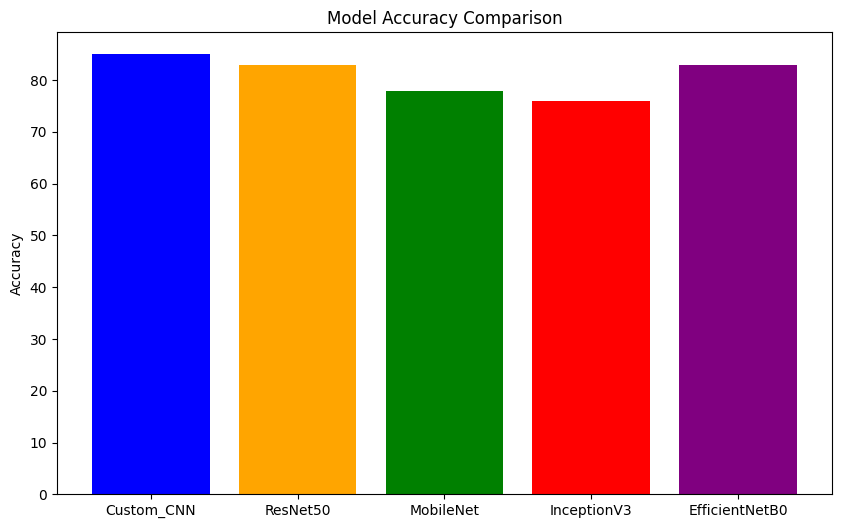

In [14]:
## Compare all models 

## Custom CNN vs ResNet50 vs MobileNet vs InceptionV3 vs EfficientNetB0 Accuracy Comparison
model_names = ['Custom_CNN', 'ResNet50', 'MobileNet', 'InceptionV3', 'EfficientNetB0']
accuracies = [85.00, 83.00, 78.00, 76.00, 83.00]   
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show() 

SAVE THE BEST MODEL

In [15]:
## Save the best model - Custom CNN model
torch.save(customcnn_model.state_dict(), 'brain_tumor_customCNN_model.pth')

STREAMLIT UI